In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QDialog, QMessageBox, QPushButton
from hw1UI import Ui_Dialog
import cv2 as cv
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
OPTIMIZER = "SGD"
PRINT_FREQ = 100
TRAIN_NUMS = 50000
def downloadMNIST():
    data_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_data = datasets.MNIST(root="./", train=True,download=True, transform=data_transform)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(range(TRAIN_NUMS)))
    
    val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(range(TRAIN_NUMS, 60000)))

    test_data = datasets.MNIST(root="./", train=False, download=True, transform=data_transform)
    
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    return train_data, train_loader, test_data, test_loader, val_loader

In [3]:
train_data, train_loader, test_data, test_loader, val_loader = downloadMNIST()

### 5.1 Show 10 images

/home/chienchia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


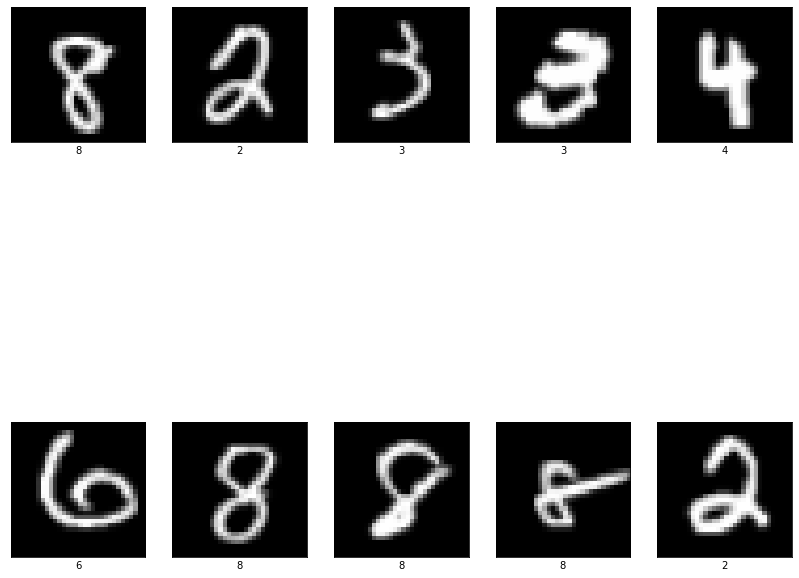

In [4]:
fig = plt.figure(figsize=(14, 14), num='5.1 10 Images and Labels of MNIST')
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    randomNum = random.randint(0,60000)
    train_image, train_image_label = train_data[randomNum]
    train_image = np.array(train_image, dtype='float')
    pixels = train_image.reshape((32, 32))
    fig.add_subplot(rows, columns, i)
    plt.xlabel(train_image_label)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pixels, cmap='gray')
fig.show()

### 5.2 Print Hyperparameters

In [5]:
print("hyperparameters:")
print("batch size:", BATCH_SIZE)
print("learning rate:", LEARNING_RATE)
print("optimizer:", OPTIMIZER)

hyperparameters:
batch size: 32
learning rate: 0.001
optimizer: SGD


### 5.3 Train 1 epoch and show training loss

In [6]:
def flatten(x):
    x = torch.flatten(x, start_dim=1)
    return x

In [7]:
LOSS=[]
LOSS_TRAIN=[]
ACC_TRAIN=[]
ACC_TEST=[]
FIG_X=[]
flag=0

class Trainer:
    def __init__(self, criterion, optimizer, device):
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.device = device
        
    def train_loop(self, model, train_loader, val_loader):
        for epoch in range(EPOCHS):
#             print("---------------- Epoch {} ----------------".format(epoch))
            self._training_step(model, train_loader, epoch)
            
            self._validate(model, val_loader, epoch)
    
    def test(self, model, test_loader):
            print("---------------- Testing ----------------")
            self._validate(model, test_loader, 0, state="Testing")
            
    def _training_step(self, model, loader, epoch):
        model.train()
        global flag
        for step, (X, y) in enumerate(loader):
            X, y = X.to(self.device), y.to(self.device)
            N = X.shape[0]
            
            self.optimizer.zero_grad()
            outs = model(X)
            loss = self.criterion(outs, y)
            
            ###################################
            LOSS.append(loss.data.item())
            FIG_X.append(flag)
            flag=flag+1
            ###################################
            
            if step >= 0 and (step % PRINT_FREQ == 0):
                self._state_logging(outs, y, loss, step, epoch, "Training")
            
            loss.backward()
            self.optimizer.step()
            
    def _validate(self, model, loader, epoch, state="Validate"):
        model.eval()
        outs_list = []
        loss_list = []
        y_list = []
        
        with torch.no_grad():
            for step, (X, y) in enumerate(loader):
                X, y = X.to(self.device), y.to(self.device)
                N = X.shape[0]
                
                outs = model(X)
                loss = self.criterion(outs, y)
                
                y_list.append(y)
                outs_list.append(outs)
                loss_list.append(loss)
            
            y = torch.cat(y_list)
            outs = torch.cat(outs_list)
            loss = torch.mean(torch.stack(loss_list), dim=0)
            self._state_logging(outs, y, loss, step, epoch, state)
            ####################################
            if(state == "Validate"):
                LOSS_TRAIN.append(loss)
                ACC_TRAIN.append(self._accuracy(outs, y))
            elif(state == "Testing"):
                ACC_TEST.append(self._accuracy(outs, y))
            ####################################
                
    def _state_logging(self, outs, y, loss, step, epoch, state):
        acc = self._accuracy(outs, y)
        print("[{:3d}/{}] {} Step {:03d} Loss {:.3f} Acc {:.3f}".format(epoch+1, EPOCHS, state, step, loss, acc))
            
    def _accuracy(self, output, target):
        batch_size = target.size(0)

        pred = output.argmax(1)
        correct = pred.eq(target)
        acc = correct.float().sum(0) / batch_size

        return acc

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1, self.conv3 = None, None
        self.sub2, self.sub4 = None, None
        self.fc1, self.fc2, self.fc3 = None, None, None
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True),
            nn.ReLU(inplace=False)
        )
        self.sub2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True),
            nn.ReLU(inplace=False)
        )
        self.sub4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=False)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(inplace=False)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        out = x
        out = self.conv1(out)
        out = self.sub2(out)
        out = self.conv2(out)
        out = self.sub4(out)
        out = flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [9]:
LOSS=[]
FIG_X=[]
flag=0

device = torch.device("cpu")
optimizer = torch.optim.SGD(params=cnn.parameters(),lr=LEARNING_RATE, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(loss_function, optimizer, device)
trainer.train_loop(cnn, train_loader, val_loader)
trainer.test(cnn, test_loader)

[  1/1] Training Step 000 Loss 2.298 Acc 0.125
[  1/1] Training Step 100 Loss 2.294 Acc 0.094
[  1/1] Training Step 200 Loss 2.251 Acc 0.312
[  1/1] Training Step 300 Loss 1.810 Acc 0.625
[  1/1] Training Step 400 Loss 0.528 Acc 0.906
[  1/1] Training Step 500 Loss 0.426 Acc 0.938
[  1/1] Training Step 600 Loss 0.320 Acc 0.812
[  1/1] Training Step 700 Loss 0.244 Acc 0.938
[  1/1] Training Step 800 Loss 0.193 Acc 0.969
[  1/1] Training Step 900 Loss 0.457 Acc 0.844
[  1/1] Training Step 1000 Loss 0.232 Acc 0.938
[  1/1] Training Step 1100 Loss 0.243 Acc 0.875
[  1/1] Training Step 1200 Loss 0.191 Acc 0.938
[  1/1] Training Step 1300 Loss 0.223 Acc 0.875
[  1/1] Training Step 1400 Loss 0.329 Acc 0.875
[  1/1] Training Step 1500 Loss 0.151 Acc 0.938
[  1/1] Validate Step 312 Loss 0.184 Acc 0.947
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.180 Acc 0.946


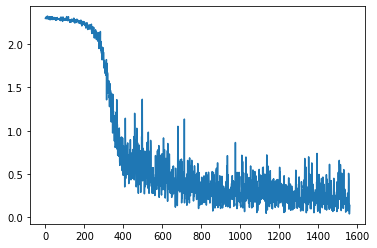

In [10]:
plt.plot(FIG_X[:len(LOSS)], LOSS)

### 5.4 Train 50 epochs

In [11]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [12]:
LOSS_TRAIN=[]
ACC_TRAIN=[]
ACC_TEST=[]
X=[]
flag=0
print("LOSS_TRAIN:", LOSS_TRAIN)
print("ACC_TRAIN:",ACC_TRAIN)
print("ACC_TEST:",ACC_TEST)
print("X:",X)

LOSS_TRAIN: []
ACC_TRAIN: []
ACC_TEST: []
X: []


In [13]:
device = torch.device("cpu")
optimizer = torch.optim.SGD(params=cnn.parameters(),lr=LEARNING_RATE, momentum=0)
loss_function = nn.CrossEntropyLoss()

for i in range(0, 50):
    print("---------------- Epoch {} ----------------".format(i))
    trainer = Trainer(loss_function, optimizer, device)
    trainer.train_loop(cnn, train_loader, val_loader)
    trainer.test(cnn, test_loader)

---------------- Epoch 0 ----------------
[  1/1] Training Step 000 Loss 2.318 Acc 0.094
[  1/1] Training Step 100 Loss 2.308 Acc 0.031
[  1/1] Training Step 200 Loss 2.294 Acc 0.188
[  1/1] Training Step 300 Loss 2.305 Acc 0.094
[  1/1] Training Step 400 Loss 2.300 Acc 0.031
[  1/1] Training Step 500 Loss 2.310 Acc 0.062
[  1/1] Training Step 600 Loss 2.303 Acc 0.125
[  1/1] Training Step 700 Loss 2.289 Acc 0.250
[  1/1] Training Step 800 Loss 2.281 Acc 0.188
[  1/1] Training Step 900 Loss 2.311 Acc 0.000
[  1/1] Training Step 1000 Loss 2.282 Acc 0.219
[  1/1] Training Step 1100 Loss 2.310 Acc 0.094
[  1/1] Training Step 1200 Loss 2.289 Acc 0.062
[  1/1] Training Step 1300 Loss 2.305 Acc 0.031
[  1/1] Training Step 1400 Loss 2.302 Acc 0.062
[  1/1] Training Step 1500 Loss 2.297 Acc 0.156
[  1/1] Validate Step 312 Loss 2.297 Acc 0.111
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 2.297 Acc 0.106
---------------- Epoch 1 ----------------
[  1/1] Training Step 0

[  1/1] Training Step 1500 Loss 0.287 Acc 0.938
[  1/1] Validate Step 312 Loss 0.192 Acc 0.945
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.198 Acc 0.945
---------------- Epoch 9 ----------------
[  1/1] Training Step 000 Loss 0.382 Acc 0.906
[  1/1] Training Step 100 Loss 0.083 Acc 1.000
[  1/1] Training Step 200 Loss 0.412 Acc 0.906
[  1/1] Training Step 300 Loss 0.138 Acc 0.938
[  1/1] Training Step 400 Loss 0.487 Acc 0.938
[  1/1] Training Step 500 Loss 0.074 Acc 0.969
[  1/1] Training Step 600 Loss 0.077 Acc 0.969
[  1/1] Training Step 700 Loss 0.148 Acc 0.938
[  1/1] Training Step 800 Loss 0.110 Acc 0.969
[  1/1] Training Step 900 Loss 0.071 Acc 0.969
[  1/1] Training Step 1000 Loss 0.112 Acc 0.969
[  1/1] Training Step 1100 Loss 0.213 Acc 0.969
[  1/1] Training Step 1200 Loss 0.132 Acc 0.969
[  1/1] Training Step 1300 Loss 0.407 Acc 0.906
[  1/1] Training Step 1400 Loss 0.247 Acc 0.906
[  1/1] Training Step 1500 Loss 0.211 Acc 0.938
[  1/1] Validate 

[  1/1] Training Step 1100 Loss 0.048 Acc 0.969
[  1/1] Training Step 1200 Loss 0.087 Acc 0.969
[  1/1] Training Step 1300 Loss 0.046 Acc 1.000
[  1/1] Training Step 1400 Loss 0.195 Acc 0.938
[  1/1] Training Step 1500 Loss 0.254 Acc 0.906
[  1/1] Validate Step 312 Loss 0.101 Acc 0.971
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.093 Acc 0.973
---------------- Epoch 18 ----------------
[  1/1] Training Step 000 Loss 0.112 Acc 0.969
[  1/1] Training Step 100 Loss 0.190 Acc 0.938
[  1/1] Training Step 200 Loss 0.053 Acc 1.000
[  1/1] Training Step 300 Loss 0.014 Acc 1.000
[  1/1] Training Step 400 Loss 0.020 Acc 1.000
[  1/1] Training Step 500 Loss 0.094 Acc 0.969
[  1/1] Training Step 600 Loss 0.359 Acc 0.906
[  1/1] Training Step 700 Loss 0.122 Acc 0.906
[  1/1] Training Step 800 Loss 0.126 Acc 0.969
[  1/1] Training Step 900 Loss 0.075 Acc 0.969
[  1/1] Training Step 1000 Loss 0.039 Acc 1.000
[  1/1] Training Step 1100 Loss 0.040 Acc 1.000
[  1/1] Training

[  1/1] Training Step 700 Loss 0.005 Acc 1.000
[  1/1] Training Step 800 Loss 0.147 Acc 0.938
[  1/1] Training Step 900 Loss 0.044 Acc 1.000
[  1/1] Training Step 1000 Loss 0.026 Acc 1.000
[  1/1] Training Step 1100 Loss 0.090 Acc 0.969
[  1/1] Training Step 1200 Loss 0.110 Acc 0.969
[  1/1] Training Step 1300 Loss 0.015 Acc 1.000
[  1/1] Training Step 1400 Loss 0.016 Acc 1.000
[  1/1] Training Step 1500 Loss 0.011 Acc 1.000
[  1/1] Validate Step 312 Loss 0.082 Acc 0.977
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.073 Acc 0.978
---------------- Epoch 27 ----------------
[  1/1] Training Step 000 Loss 0.042 Acc 1.000
[  1/1] Training Step 100 Loss 0.079 Acc 0.969
[  1/1] Training Step 200 Loss 0.024 Acc 1.000
[  1/1] Training Step 300 Loss 0.088 Acc 0.969
[  1/1] Training Step 400 Loss 0.117 Acc 0.969
[  1/1] Training Step 500 Loss 0.290 Acc 0.938
[  1/1] Training Step 600 Loss 0.018 Acc 1.000
[  1/1] Training Step 700 Loss 0.066 Acc 0.938
[  1/1] Training 

[  1/1] Training Step 300 Loss 0.011 Acc 1.000
[  1/1] Training Step 400 Loss 0.020 Acc 1.000
[  1/1] Training Step 500 Loss 0.026 Acc 1.000
[  1/1] Training Step 600 Loss 0.212 Acc 0.938
[  1/1] Training Step 700 Loss 0.034 Acc 1.000
[  1/1] Training Step 800 Loss 0.035 Acc 1.000
[  1/1] Training Step 900 Loss 0.005 Acc 1.000
[  1/1] Training Step 1000 Loss 0.105 Acc 0.969
[  1/1] Training Step 1100 Loss 0.023 Acc 1.000
[  1/1] Training Step 1200 Loss 0.146 Acc 0.938
[  1/1] Training Step 1300 Loss 0.009 Acc 1.000
[  1/1] Training Step 1400 Loss 0.019 Acc 1.000
[  1/1] Training Step 1500 Loss 0.074 Acc 0.938
[  1/1] Validate Step 312 Loss 0.069 Acc 0.979
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.059 Acc 0.982
---------------- Epoch 36 ----------------
[  1/1] Training Step 000 Loss 0.008 Acc 1.000
[  1/1] Training Step 100 Loss 0.107 Acc 0.969
[  1/1] Training Step 200 Loss 0.061 Acc 0.969
[  1/1] Training Step 300 Loss 0.003 Acc 1.000
[  1/1] Training 

[  1/1] Testing Step 312 Loss 0.049 Acc 0.984
---------------- Epoch 44 ----------------
[  1/1] Training Step 000 Loss 0.007 Acc 1.000
[  1/1] Training Step 100 Loss 0.258 Acc 0.906
[  1/1] Training Step 200 Loss 0.061 Acc 1.000
[  1/1] Training Step 300 Loss 0.013 Acc 1.000
[  1/1] Training Step 400 Loss 0.003 Acc 1.000
[  1/1] Training Step 500 Loss 0.006 Acc 1.000
[  1/1] Training Step 600 Loss 0.017 Acc 1.000
[  1/1] Training Step 700 Loss 0.010 Acc 1.000
[  1/1] Training Step 800 Loss 0.009 Acc 1.000
[  1/1] Training Step 900 Loss 0.004 Acc 1.000
[  1/1] Training Step 1000 Loss 0.014 Acc 1.000
[  1/1] Training Step 1100 Loss 0.027 Acc 1.000
[  1/1] Training Step 1200 Loss 0.009 Acc 1.000
[  1/1] Training Step 1300 Loss 0.008 Acc 1.000
[  1/1] Training Step 1400 Loss 0.009 Acc 1.000
[  1/1] Training Step 1500 Loss 0.008 Acc 1.000
[  1/1] Validate Step 312 Loss 0.058 Acc 0.983
---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.048 Acc 0.985
---------------- E

In [14]:
torch.save(cnn.state_dict(), "./model")

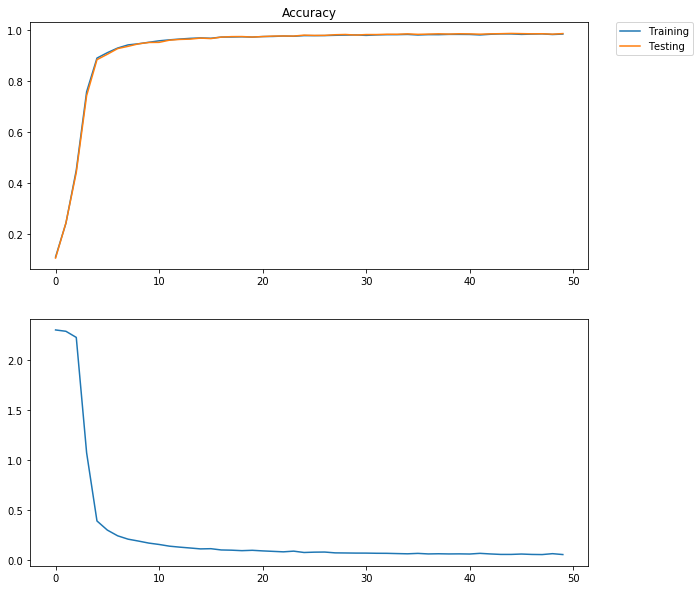

In [15]:
plt.figure(figsize=(10, 10), num='5.4 Training Result')
plt.subplot(211)
plt.plot(FIG_X[0:len(ACC_TRAIN)], ACC_TRAIN, label="Training")
plt.plot(FIG_X[0:len(ACC_TEST)], ACC_TEST, label="Testing")
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(212)
plt.plot(FIG_X[0:len(LOSS_TRAIN)], LOSS_TRAIN)

plt.show()

In [16]:
model = CNN()
model.load_state_dict(torch.load("./model"))
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (sub4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [17]:
trainer.test(model, test_loader)

---------------- Testing ----------------
[  1/1] Testing Step 312 Loss 0.047 Acc 0.985


In [18]:
testIndex = 0
print(testIndex)

0


/home/chienchia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


<BarContainer object of 10 artists>

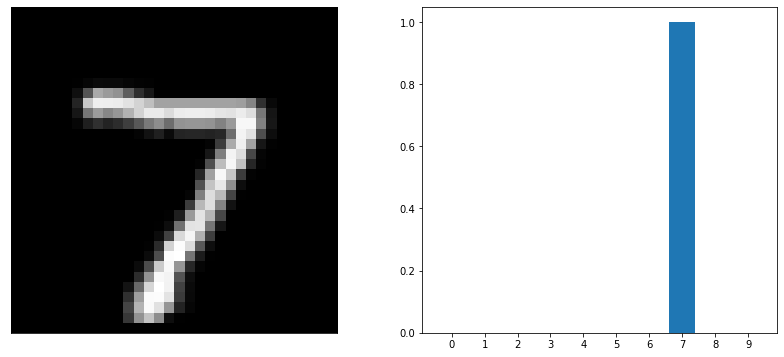

In [19]:
fig = plt.figure(figsize=(14, 6), num='5.5')
TEST_IMAGE, test_image_label = test_data[testIndex]
test_image = np.array(TEST_IMAGE, dtype='float')
pixels = test_image.reshape((32, 32))
fig.add_subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(pixels, cmap='gray')
fig.show()

# Test Model
model.eval()
test = DataLoader(test_data[testIndex])
test_x, test_y = test
output = model(test_x)
output = F.softmax(output, dim=1)
output = output.tolist()[0]

outputProbLabel = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig.add_subplot(1, 2, 2)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.bar(outputProbLabel, output)